For this homework, make sure that you format your notbook nicely and cite all sources in the appropriate sections. Programmatically generate or embed any figures or graphs that you need.

Names: __Shaan Hossain, Jinesh Shailesh Mehta__

Step 1: Train your own word embeddings
--------------------------------

(describe the provided dataset that you have chosen here)

Describe what data set you have chosen to compare and contrast with the your chosen provided dataset. Make sure to describe where it comes from and it's general properties.

(describe your dataset here)

In [157]:
# import your libraries here

from typing import List
from gensim.parsing.preprocessing import stem_text, remove_stopwords, strip_punctuation
# import keras
# import numpy 
# import pandas
import scipy
import sklearn
from nltk.tokenize import RegexpTokenizer
from csv import reader
from gensim.models import Word2Vec
from gensim.test.utils import common_texts
from gensim.models import KeyedVectors
import multiprocessing
from collections import Counter
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline


### a) Train embeddings on GIVEN dataset

In [158]:
'''
TODO: Questions to submit
1. Do we need to worry about the training time? Can we submit a pretrained model
or is part of training what you want to see.
2. Do we need to train on both of the datasets
'''

'''
NOTE: For pre processing
1. lower
2. remove punctuation
3. remove stopwords
4. Add <s> and </s> for every sentence.
'''

'''
TODO: Jinesh
1. Parsing the custom dataset
2. Pre processing function - Completed.

parse_data -> preprocessing ->

TODO: Shaan
1. Get the infrastructure for the model set up to accept data from preprocessing
'''

'\nTODO: Jinesh\n1. Parsing the custom dataset\n2. Pre processing function - Completed.\n\nparse_data -> preprocessing ->\n\nTODO: Shaan\n1. Get the infrastructure for the model set up to accept data from preprocessing\n'

In [159]:
# code to train your word embeddings

# Read the file and prepare the training data 
# so that it is in the following format

data = [['this', 'is', 'the', 'first', 'sentence', 'for', 'word2vec'],
			['this', 'is', 'the', 'second', 'sentence'],
			['yet', 'another', 'sentence'],
			['one', 'more', 'sentence'],
			['and', 'the', 'final', 'sentence']]

def parse_data(training_file_path: str, percentage: int, select_column:int) -> List[str]:
  """This function is used to parse input lines
  and returns a the provided percent of data.

  Args:
      lines (List[str]): list of lines
      percentage (int): percent of the dataset needed
      select_column (int): column to be selected from the dataset
  Returns:
      List[str]: lines (percentage of dataset)
  """
  sentences = []
  percentage_sentences = []
  with open(training_file_path, "r", encoding="utf8", errors="ignore") as csvfile:
    csv_reader = reader(csvfile)

    # csv_reader_copy = csv_reader.copy()

    #skipping header
    header = next(csv_reader)

    # line_length = len(list(csv_reader_copy))
   
    if header != None:
      for row in csv_reader:
        sentences.append(row[select_column])

    end_of_data = int(len(sentences) * percentage * .01)
    percentage_sentences = sentences[0:end_of_data]

  return percentage_sentences

In [160]:
# "I am sam. Sam I am. What time is it?" 
# -> 
# List of sentences [<s> I am sam </s>, <s> Sam I am </s> ...]

def preprocessing(running_lines: List[str]) -> List[List[str]]:
  """This function takes in the running test and return back the
  preprocessed text. Four tasks are done as part of this:
    1. lower word case
    2. remove stopwords
    3. remove punctuation
    4. Add <s> and </s> for every sentence

  Args:
      running_lines (List[str]): list of lines

  Returns:
      List[List[str]]: list of sentences where each sentence is broken
                        into list of words.
  """
  preprocessed_lines = []
  tokenizer = RegexpTokenizer(r'\w+')
  for line in running_lines:
    lower_case_data = line.lower()
    data_without_stop_word = remove_stopwords(lower_case_data)
    data_without_punct = strip_punctuation(data_without_stop_word)
    processed_data = tokenizer.tokenize(data_without_punct)
    processed_data.insert(0,"<s>")
    processed_data.append("</s>")
    preprocessed_lines.append(processed_data)
  return preprocessed_lines

In [161]:
# parse and preprocess provided data
print("Tokenizing Provided Dataset: Spooky Dataset\n")
spooky_sentences = preprocessing(parse_data("data/provided/train/train.csv", .05, 1))
for token in spooky_sentences:
  print(token)
# parse and preprocess custom data
print("\nTokenizing Custom Dataset: Corona Tweets\n")
covid_sentences = preprocessing(parse_data("data/custom/train/Corona_NLP_train.csv", .05, 4))
for token in covid_sentences:
  print(token)

Tokenizing Provided Dataset: Spooky Dataset

['<s>', 'process', 'however', 'afforded', 'means', 'ascertaining', 'dimensions', 'dungeon', 'circuit', 'return', 'point', 'set', 'out', 'aware', 'fact', 'perfectly', 'uniform', 'wall', '</s>']
['<s>', 'occurred', 'fumbling', 'mere', 'mistake', '</s>']
['<s>', 'left', 'hand', 'gold', 'snuff', 'box', 'which', 'capered', 'hill', 'cutting', 'manner', 'fantastic', 'steps', 'took', 'snuff', 'incessantly', 'air', 'greatest', 'possible', 'self', 'satisfaction', '</s>']
['<s>', 'lovely', 'spring', 'looked', 'windsor', 'terrace', 'sixteen', 'fertile', 'counties', 'spread', 'beneath', 'speckled', 'happy', 'cottages', 'wealthier', 'towns', 'looked', 'years', 'heart', 'cheering', 'fair', '</s>']
['<s>', 'finding', 'else', 'gold', 'superintendent', 'abandoned', 'attempts', 'perplexed', 'look', 'occasionally', 'steals', 'countenance', 'sits', 'thinking', 'desk', '</s>']
['<s>', 'youth', 'passed', 'solitude', 'best', 'years', 'spent', 'gentle', 'feminine', 

# Step-1.4 Choosing the dataset:
Coronavirus tweets NLP
https://www.kaggle.com/datatattle/covid-19-nlp-text-classification
 

In [162]:
# The dimension of word embedding. 
# This variable will be used throughout the program
# you may vary this as you desire
EMBEDDINGS_SIZE = 200

# Train the Word2Vec model from Gensim. 
# Below are the hyperparameters that are most relevant. 
# But feel free to explore other 
# options too:
sg = 1 # The training algorithm, either CBOW(0) or skip gram(1). The default training algorithm is CBOW.
window = 5
size = EMBEDDINGS_SIZE
min_count = 1
workers = multiprocessing.cpu_count()
sorted_vocab = 1 #1 for descending order

def generate_embeddings(model_name: str, sentences: List[List[str]]) -> (str, str):

    model = Word2Vec(
        sentences=sentences, 
        vector_size=size, 
        window=window, 
        min_count=min_count, 
        workers=workers, 
        sg=sg,
        sorted_vocab=sorted_vocab)
    model_path = "word2vec." + model_name + ".model"
    model.save(model_path)

    # Store just the words + their trained embeddings.
    word_vectors_path = "word2vec." + model_name + ".wordvectors"
    word_vectors = model.wv
    word_vectors.save(word_vectors_path)

    return model_path, word_vectors_path

spooky_model_path, spooky_word_vectors_path = generate_embeddings("spooky", spooky_sentences)

# model = Word2Vec.load("word2vec.model")
# wv = KeyedVectors.load("word2vec.wordvectors", mmap='r')
# vector = wv['computer']  # Get numpy vector of a word
# print(vector);

In [163]:
# if you save your Word2Vec as the variable model, this will 
# print out the vocabulary size
model = Word2Vec.load(spooky_model_path)
print('Vocab size {}'.format(len(model.wv)))

# print('Word counts {}'.format(model.))

Vocab size 159


In [164]:
# You can save file in txt format, then load later if you wish.
model.wv.save_word2vec_format('embeddings.txt', binary=False)

### b) Train embedding on YOUR dataset

In [165]:
# then do a second data set
covid_model_path, covid_word_vectors_path = generate_embeddings("covid", covid_sentences)


What text-normalization and pre-processing did you do and why? __YOUR ANSWER HERE__

Step 2: Evaluate the differences between the word embeddings
----------------------------

(make sure to include graphs, figures, and paragraphs with full sentences)

Shaan:
- Dump the images for both models with varying perplexity values
- Figure out which images we're going to do analysis on 3-10
- Figure out which features we're going to write about

Jinesh:
- Separating functionality into different cells
- Making sure the code still works

For next time:
- Analysis on the images
- Training feed forward neural network
- Generation of sentences and comparing sentences

/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you inte

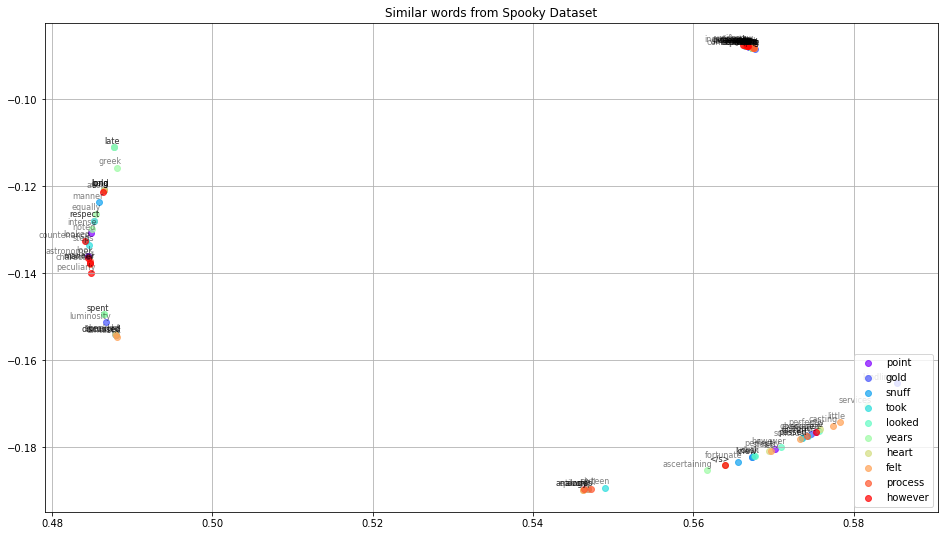

In [166]:
wv_spooky = KeyedVectors.load(spooky_word_vectors_path, mmap='r')
wv_covid = KeyedVectors.load(covid_word_vectors_path, mmap='r')

def get_top_k_words(sentences, k):

    word_counts = Counter()

    for sentence in sentences:
        for i in sentence:
            word_counts[i] += 1

    word_counts["<s>"] = 0
    word_counts["</s>"] = 0

    k_most_common = []

    for i in word_counts.most_common(k):
        k_most_common.append(i[0])

    # print(word_counts.most_common(k)) //Seeing the corresponding counts
    return k_most_common

keys  = get_top_k_words(spooky_sentences, 10)
# print(keys) 

# print(model.wv.most_similar(keys[0], topn=10))

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    # print(model.wv.most_similar(word, topn=10))
    for similar_word, _ in model.wv.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(model.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

# for i in word_clusters:
#     print(i)

# for i in embedding_clusters:
#     print(i)

def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, perplexity, filename=None):

    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    tsne_model_en_2d = TSNE(perplexity=perplexity, n_components=2, init='pca', n_iter=3500, random_state=32)
    embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embeddings_en_2d, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

# for i in range(1, 30, 3):
#     file_name = 'similar_words_perplexity_' + str(i) + '.png'
#     tsne_plot_similar_words('Similar words from Spooky Dataset', keys, embedding_clusters, word_clusters, 0.7, i,
#     file_name)

perplexity = 100
file_name = 'similar_words_perplexity_' + str(perplexity) + '.png'
tsne_plot_similar_words('Similar words from Spooky Dataset', keys, embedding_clusters, word_clusters, 0.7, perplexity,
    file_name)




##Write down your analysis:

Cite your sources:
-------------

Step 3: Feedforward Neural Language Model
--------------------------

### a) First, encode  your text into integers

In [167]:
# Importing utility functions from Keras
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Embedding

# The size of the ngram language model you want to train
# change as needed for your experiments
NGRAM = 3 

# Initializing a Tokenizer
# It is used to vectorize a text corpus. Here, it just creates a mapping from 
# word to a unique index. (Note: Indexing starts from 0)
# Example:
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(data)
# encoded = tokenizer.texts_to_sequences(data)


ImportError: cannot import name 'to_categorical' from 'keras.utils' (/usr/local/lib/python3.9/site-packages/keras/utils/__init__.py)

### b) Next, prepare your sequences from text

#### Fixed ngram based sequences 

In [ ]:
def generate_ngram_training_samples(ngram: list) -> list:
    '''
    Takes the encoded data (list of lists) and 
    generates the training samples out of it.
    Parameters:
    up to you, we've put in what we used
    but you can add/remove as needed
    return: 
    list of lists in the format [[x1, x2, ... , x(n-1), y], ...]
    '''
    pass


### c) Then, split the sequences into X and y and create a Data Generator

In [ ]:
# Note here that the sequences were in the form: 
# sequence = [x1, x2, ... , x(n-1), y]
# We still need to separate it into [[x1, x2, ... , x(n-1)], ...], [y1, y2, ...]

In [ ]:
def read_embeddings():
    '''Loads and parses embeddings trained in earlier.
    Parameters and return values are up to you.
    '''
    
    # you may find generating the following two dicts useful:
    # word to embedding : {'the':[0....], ...}
    # index to embedding : {1:[0....], ...} 
    # use your tokenizer's word_index to find the index of
    # a given word
    pass



In [ ]:
def data_generator(X: list, y: list, num_sequences_per_batch: int) -> (list,list):
    '''
    Returns data generator to be used by feed_forward
    https://wiki.python.org/moin/Generators
    https://realpython.com/introduction-to-python-generators/
    
    Yields batches of embeddings and labels to go with them.
    Use one hot vectors to encode the labels 
    (see the to_categorical function)
    
    '''
    pass



In [ ]:
# Examples
# initialize data_generator
# num_sequences_per_batch = 128 # this is the batch size
# steps_per_epoch = len(sequences)//num_sequences_per_batch  # Number of batches per epoch
# train_generator = data_generator(X, y, num_sequences_per_batch)

# sample=next(train_generator) # this is how you get data out of generators
# sample[0].shape # (batch_size, (n-1)*EMBEDDING_SIZE)  (128, 200)
# sample[1].shape   # (batch_size, |V|) to_categorical

### d) Train your models

In [ ]:
# code to train a feedforward neural language model 
# on a set of given word embeddings
# make sure not to just copy + paste to train your two models

# Define the model architecture using Keras Sequential API



In [ ]:
# Start training the model
model.fit(x=train_generator, 
          steps_per_epoch=steps_per_epoch,
          epochs=1)

### e) Generate Sentences

In [ ]:
# generate a sequence from the model
def generate_seq(model: Sequential, 
                 tokenizer: Tokenizer, 
                 seed: list, 
                 n_words: int):
    '''
    Parameters:
        model: your neural network
        tokenizer: the keras preprocessing tokenizer
        seed: [w1, w2, w(n-1)]
        n_words: generate a sentence of length n_words
    Returns: string sentence
    '''
    pass

### f) Compare your generated sentences

Sources Cited
----------------------------
